In [1]:
!pip install torch torchvision
!pip install pandas numpy scikit-learn matplotlib seaborn
!pip install tqdm
!pip install xgboost lightgbm
!pip install -q dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 64.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import shap

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import os

print("Installing condacolab")
!pip install -q condacolab
import condacolab
condacolab.install()

In [3]:
import os

print("Creating Python 3.8 environment")
!conda create -n tabcbm_env python=3.8 -y -q

print("Installing dependencies for TabCBM")
!conda run -n tabcbm_env pip install -q \
  anndata cachetools captum cmake colorama commonmark \
  configobj configparser dill h5py joblib keras Keras-Preprocessing \
  numba numexpr "numpy<1.25" "pandas<2.1" Pillow \
  prettytable pyaml pytorch-lightning pytorch-tabnet PyYAML \
  scanpy scikit-image "scikit-learn>=1.0.2" scikit-learn-extra \
  scipy setuptools-scm tensorflow

print("Cloning TabCBM repository")
!rm -rf /tmp/tabcbm
!git clone -q https://github.com/mateoespinosa/tabcbm.git /tmp/tabcbm

# Step 4: Fix sklearn dependency issue
print("Fixing sklearn dependency issue")
!cd /tmp/tabcbm && sed -i '/^sklearn/d' requirements.txt

# Step 5: Fix concepts_xai import issues
print("Fixing concepts_xai import issues")

fix_imports_script = """
import os
import sys

fixed_files = []
init_file = '/tmp/tabcbm/tabcbm/concepts_xai/__init__.py'

# Fix the main __init__.py
try:
    with open(init_file, 'r') as f:
        content = f.read()

    content = content.replace('from concepts_xai.', 'from tabcbm.concepts_xai.')
    content = content.replace('import concepts_xai.', 'import tabcbm.concepts_xai.')

    with open(init_file, 'w') as f:
        f.write(content)
    fixed_files.append(init_file)
except Exception as e:
    print(f"Error fixing {init_file}: {e}")

# Fix all other Python files in concepts_xai
for root, dirs, files in os.walk('/tmp/tabcbm/tabcbm/concepts_xai'):
    for file in files:
        if file.endswith('.py') and file != '__init__.py':
            filepath = os.path.join(root, file)
            try:
                with open(filepath, 'r') as f:
                    content = f.read()

                original_content = content
                content = content.replace('from concepts_xai.', 'from tabcbm.concepts_xai.')
                content = content.replace('import concepts_xai.', 'import tabcbm.concepts_xai.')

                if content != original_content:
                    with open(filepath, 'w') as f:
                        f.write(content)
                    fixed_files.append(filepath)
            except Exception as e:
                pass

print(f"Fixed {len(fixed_files)} files")
"""

with open('/tmp/fix_imports.py', 'w') as f:
    f.write(fix_imports_script)

!python /tmp/fix_imports.py

# Step 6: Install TabCBM
print("Installing TabCBM")
!conda run -n tabcbm_env pip install --no-deps -e /tmp/tabcbm -q

# Verification
verification_script = """
import sys
import warnings
warnings.filterwarnings('ignore')

try:
    # Test imports
    import tabcbm
    from tabcbm.models.tabcbm import TabCBM
    import tensorflow as tf
    import numpy as np

    print("\\n✅ TabCBM successfully installed!")

except Exception as e:
    print(f"\\n❌ Error during verification: {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)
"""

with open('/tmp/verify_installation.py', 'w') as f:
    f.write(verification_script)

!conda run -n tabcbm_env python /tmp/verify_installation.py

Creating Python 3.8 environment
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local/envs/tabcbm_env

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bzip2-1.0.8                |       hda65f42_8         254 KB  conda-forge
    ca-certificates-2025.11.12 |       hbd8a1cb_0         149 KB  conda-forge
    icu-75.1                   |       he02047a_0        11.6 MB  conda-forge
    ld_impl_linux-64-2.45      |       h1aa0949_0         736 KB  conda-forge
    libffi-3.5.2               |       h9ec8514_0          56 KB  conda-forge
    libgcc-15.2.0              |       h767d61c_7         803 KB  conda-forge
    libgcc-ng-15.2.0           |       h69a702a_7          29 KB  conda-forge
    libgomp-15.2.0             |       h767d61c_7         437 KB  conda-forge

In [4]:
import requests
import pandas as pd

url = "https://github.com/IIIS-Datathon/datathon2025-challenges/raw/main/Schneider%20Electric/dataset.csv"
file_path = "dataset.csv"

# Download the file
print(f"Downloading {file_path} from {url}...")
response = requests.get(url, stream=True)
response.raise_for_status() # Raise an exception for HTTP errors

with open(file_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print("Download complete -> Loading into DataFrame")

df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
print(f"\nFirst few rows:")
display(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nTarget variable distribution:")
print(df['target_variable'].value_counts())

Download complete -> Loading into DataFrame
Dataset shape: (35899, 17)

Column names:
['id', 'product_A_sold_in_the_past', 'product_B_sold_in_the_past', 'product_A_recommended', 'product_A', 'product_C', 'product_D', 'cust_hitrate', 'cust_interactions', 'cust_contracts', 'opp_month', 'opp_old', 'competitor_Z', 'competitor_X', 'competitor_Y', 'cust_in_iberia', 'target_variable']

First few rows:


,id,product_A_sold_in_the_past,product_B_sold_in_the_past,product_A_recommended,product_A,product_C,product_D,cust_hitrate,cust_interactions,cust_contracts,opp_month,opp_old,competitor_Z,competitor_X,competitor_Y,cust_in_iberia,target_variable
0,1,-0.25992,-0.34794,-0.1097,-0.0891,-0.02372,-0.04247,0.12643,0.30731,-0.34997,-1.41464,-0.28185,0,0,0,1,1
1,2,-0.25992,-0.28599,-0.1097,-0.0891,-0.02372,-0.04247,0.42465,3.26349,0.92184,-1.11923,3.54793,1,0,0,0,0
2,3,-0.25992,-0.18998,-0.1097,-0.0891,-0.02372,-0.04247,0.72559,1.29633,-0.34997,0.65323,-0.28185,0,0,0,0,0
3,4,0.65945,3.35306,-0.1097,-0.0891,-0.02372,-0.04247,1.55091,-0.68170,3.46544,1.24404,-0.28185,0,0,0,1,0
4,5,-0.25992,-0.24623,-0.1097,-0.0891,-0.02372,-0.04247,-0.50193,0.65510,-0.03202,1.53945,-0.28185,1,0,0,0,0



Data types:
id                              int64
product_A_sold_in_the_past    float64
product_B_sold_in_the_past    float64
product_A_recommended         float64
product_A                     float64
product_C                     float64
product_D                     float64
cust_hitrate                  float64
cust_interactions             float64
cust_contracts                float64
opp_month                     float64
opp_old                       float64
competitor_Z                    int64
competitor_X                    int64
competitor_Y                    int64
cust_in_iberia                  int64
target_variable                 int64
dtype: object

Target variable distribution:
target_variable
0    19009
1    16890
Name: count, dtype: int64


In [17]:
# Identify feature types
target_col = 'target_variable'
id_col = 'id'

# Separate features
feature_cols = [col for col in df.columns if col not in [target_col, id_col]]

# Identify categorical and numerical features
categorical_features = []
numerical_features = []

for col in feature_cols:
    if df[col].dtype == 'object' or df[col].nunique() < 10:
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

Categorical features (5): ['opp_old', 'competitor_Z', 'competitor_X', 'competitor_Y', 'cust_in_iberia']
Numerical features (10): ['product_A_sold_in_the_past', 'product_B_sold_in_the_past', 'product_A_recommended', 'product_A', 'product_C', 'product_D', 'cust_hitrate', 'cust_interactions', 'cust_contracts', 'opp_month']


In [18]:
# Prepare data
X = df[feature_cols].copy()
y = df[target_col].values

# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Split data: 80% train, 20% temp (which will be 10% val, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split temp into 50% validation, 50% test (resulting in 10% val, 10% test overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Standardize numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Validation target distribution: {np.bincount(y_val)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Train set: (28719, 15), Validation set: (3590, 15), Test set: (3590, 15)
Train target distribution: [15207 13512]
Validation target distribution: [1901 1689]
Test target distribution: [1901 1689]


# Using RandomForest to extract some initial information

Starting Grid Search for RandomForestClassifier using X_val for selection...
Fitting 1 folds for each of 180 candidates, totalling 180 fits

Grid Search complete.
Best parameters found: {'max_depth': np.int64(30), 'n_estimators': np.int64(35)}
Best validation accuracy (from X_val): 0.8454

Train Accuracy (Best Model): 0.9519
Validation Accuracy (Best Model): 0.9515
Test Accuracy (Best Model): 0.8468

Classification Report (Best Model on Test Set):
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1901
           1       0.82      0.86      0.84      1689

    accuracy                           0.85      3590
   macro avg       0.85      0.85      0.85      3590
weighted avg       0.85      0.85      0.85      3590



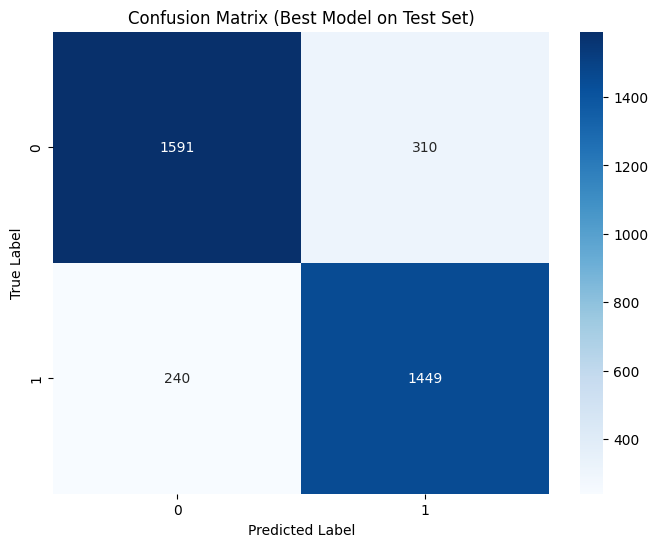

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, PredefinedSplit
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define parameter grid to search
param_grid = {
    'n_estimators': np.arange(10, 100, 5),
    'max_depth': np.arange(25, 75, 5),
}

# Initialize a RandomForestClassifier with default parameters for grid search
base_classifier = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

# --- Custom setup to use X_val for hyperparameter selection ---
# Combine training and validation sets
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = np.concatenate([y_train, y_val])

# Create a list where -1 indicates training data and 0 indicates validation data
# for a single predefined split (X_val will act as the test set for GridSearchCV)
test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
ps = PredefinedSplit(test_fold)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_classifier,
    param_grid=param_grid,
    cv=ps, # Use the PredefinedSplit which designates X_val as the validation fold
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=1, # Print progress
    refit=True # Refit on X_train_val using best parameters found
)

print("Starting Grid Search for RandomForestClassifier using X_val for selection...")
grid_search.fit(X_train_val, y_train_val) # Fit on combined data, but split by ps

print("\nGrid Search complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best validation accuracy (from X_val): {grid_search.best_score_:.4f}")

# Use the best estimator found by GridSearchCV (it's already refitted on X_train_val)
classifier = grid_search.best_estimator_

# Evaluate the best classifier on X_test (final, unseen data)
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val) # Evaluate on X_val explicitly for reporting
y_pred_test = classifier.predict(X_test)

print(f"\nTrain Accuracy (Best Model): {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Validation Accuracy (Best Model): {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Test Accuracy (Best Model): {accuracy_score(y_test, y_pred_test):.4f}")
print(f"\nClassification Report (Best Model on Test Set):")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best Model on Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
import joblib

# Save the best classifier (trained on the full feature set)
joblib.dump(classifier, 'random_forest_classifier.joblib')
print("Random Forest Classifier (full features) saved to random_forest_classifier.joblib")

Random Forest Classifier (full features) saved to random_forest_classifier.joblib


In [ ]:
print("Generating SHAP Feature Importance")
explainer = shap.TreeExplainer(classifier)

# Sample test data for faster computation
shap_values = explainer.shap_values(X_test)


Feature Importance
Top 10 Most Important Features:
                       feature  importance
6                 cust_hitrate    0.320709
7            cust_interactions    0.197692
9                    opp_month    0.139657
1   product_B_sold_in_the_past    0.119496
8               cust_contracts    0.053652
0   product_A_sold_in_the_past    0.051689
10                     opp_old    0.031536
13                competitor_Y    0.020040
14              cust_in_iberia    0.018629
2        product_A_recommended    0.017705


/tmp/ipython-input-2657240864.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


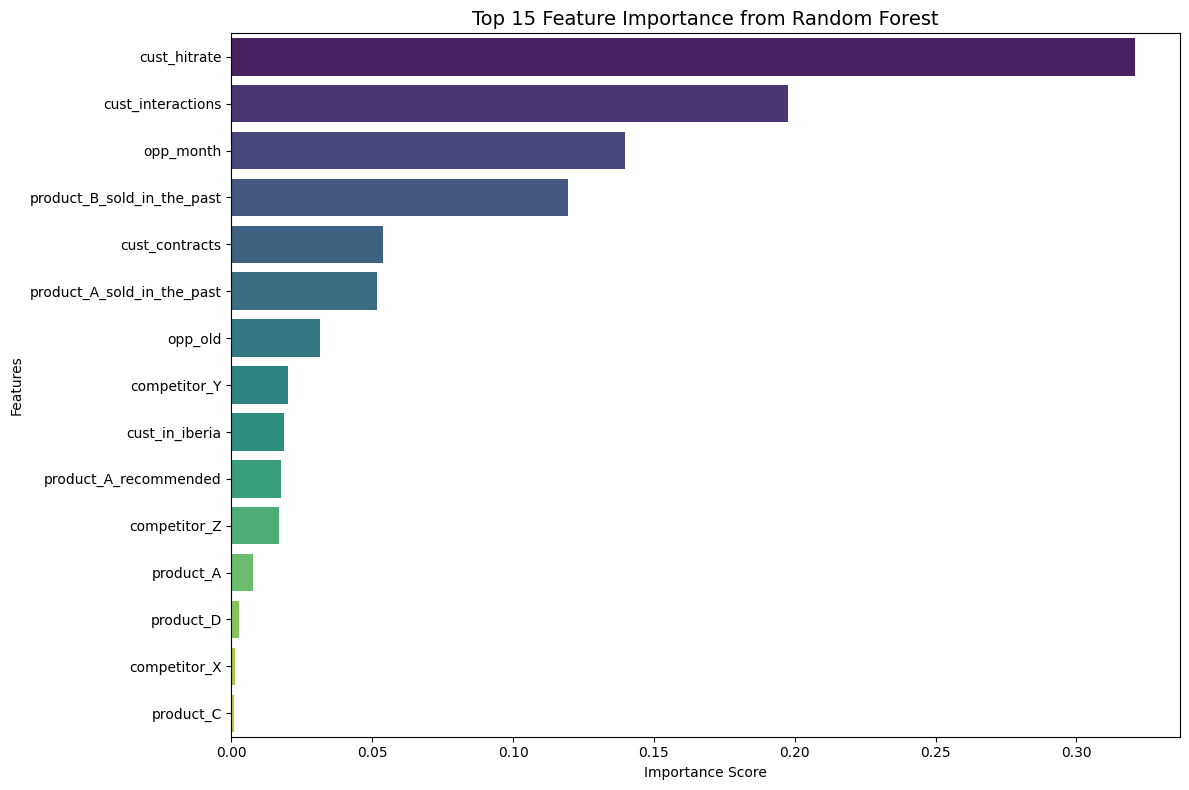

In [19]:
print("Feature Importance")
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance_df))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(top_n),
    palette='viridis'
)
plt.title(f'Top {top_n} Feature Importance from Random Forest', fontsize=14)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Training a TabCBM to further insights

In [ ]:
examine_script = """
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/dataset.csv')

print("="*70)
print("📊 Dataset Overview")
print("="*70)

print(f"\\n🔍 Dataset Shape: {df.shape}")
print(f"   • Rows: {df.shape[0]}")
print(f"   • Columns: {df.shape[1]}")

print(f"\\n📋 Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i}. {col} (dtype: {df[col].dtype})")

print(f"\\n📈 First Few Rows:")
print(df.head(10))

print(f"\\n🔢 Basic Statistics:")
print(df.describe())

print(f"\\n❓ Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("   No missing values!")

print(f"\\n🎯 Data Types Summary:")
print(df.dtypes.value_counts())

# Check for potential target columns
potential_targets = ['target', 'label', 'class', 'y', 'outcome', 'diagnosis', 'prediction']
target_col = None
for col in df.columns:
    if col.lower() in potential_targets:
        target_col = col
        print(f"\\n✅ Potential target column found: '{target_col}'")
        print(f"   Unique values: {df[target_col].nunique()}")
        print(f"   Value counts:")
        print(df[target_col].value_counts())
        break

if target_col is None:
    print(f"\\n⚠️  No obvious target column found.")
    print(f"   Assuming last column ('{df.columns[-1]}') is the target.")
    print(f"   Unique values: {df[df.columns[-1]].nunique()}")
    print(f"   Value counts:")
    print(df[df.columns[-1]].value_counts())

print("\\n" + "="*70)
"""

with open('/tmp/examine_dataset.py', 'w') as f:
    f.write(examine_script)

!conda run -n tabcbm_env python /tmp/examine_dataset.py

In [ ]:
tabcbm_training_script = """
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tabcbm.models.tabcbm import TabCBM

print("="*70)
print("🚀 TabCBM Training Pipeline")
print("="*70)

# ============================================================================
# 1-4. Data Loading and Preprocessing
# ============================================================================
print("\\n[1/7] 📊 Loading dataset...")
df = pd.read_csv('/content/dataset.csv')
print(f"  • Dataset shape: {df.shape}")

TARGET_COLUMN = df.columns[-1]
print(f"  • Target column: '{TARGET_COLUMN}'")

X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

print("\\n[2/7] 🔧 Preprocessing data...")

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print(f"  • Found {len(categorical_cols)} categorical columns")
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

if y.dtype == 'object' or y.dtype.name == 'category':
    print(f"  • Encoding target variable...")
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    n_classes = len(le_target.classes_)
    print(f"  • Classes: {list(le_target.classes_)}")
else:
    n_classes = len(np.unique(y))

print(f"  • Number of classes: {n_classes}")

if X.isnull().any().any():
    print(f"  • Filling missing values...")
    X = X.fillna(X.mean())

print("\\n[3/7] ✂️  Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"  • Training samples: {X_train.shape[0]}")
print(f"  • Testing samples: {X_test.shape[0]}")

print("\\n[4/7] 📏 Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

n_features = X_train_scaled.shape[1]
print(f"  • Number of features: {n_features}")

# ============================================================================
# 5. Build TabCBM Model
# ============================================================================
print("\\n[5/7] 🏗️  Building TabCBM model...")

N_CONCEPTS = min(4, n_features)
LATENT_DIMS = N_CONCEPTS

BATCH_SIZE = 64
EPOCHS_PRETRAIN = 30
EPOCHS_TRAIN = 50

print(f"  • Number of concepts: {N_CONCEPTS}")
print(f"  • Latent dimensions: {LATENT_DIMS}")
print(f"  • Input features: {n_features}")

features_to_concepts = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_features,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(LATENT_DIMS, activation='relu')
], name='features_to_concepts')

concepts_to_labels = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(N_CONCEPTS,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
], name='concepts_to_labels')

g_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(LATENT_DIMS,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_features, activation='linear')
], name='reconstruction_model')

print("  ✅ Model architecture defined")

# ============================================================================
# 6. Self-Supervised Pre-training
# ============================================================================
print("\\n[6/7] 🔄 Self-supervised pre-training...")

tabcbm_pretrain = TabCBM(
    features_to_concepts_model=features_to_concepts,
    concepts_to_labels_model=concepts_to_labels,
    g_model=g_model,
    latent_dims=LATENT_DIMS,
    n_concepts=N_CONCEPTS,
    n_supervised_concepts=0,
    coherence_reg_weight=0.1,
    diversity_reg_weight=15.0,
    feature_selection_reg_weight=2.0,
    gate_estimator_weight=0.1,
    concept_generator_units=[32],
    self_supervised_mode=True
)

tabcbm_pretrain.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

print(f"  • Pre-training for {EPOCHS_PRETRAIN} epochs...")

history_pretrain = tabcbm_pretrain.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS_PRETRAIN,
    batch_size=BATCH_SIZE,
    verbose=0
)

print(f"  ✅ Pre-training complete (Final loss: {history_pretrain.history['loss'][-1]:.4f})")

# ============================================================================
# 7. Supervised Training
# ============================================================================
print("\\n[7/7] 🎓 Supervised training...")

tabcbm = TabCBM(
    features_to_concepts_model=features_to_concepts,
    concepts_to_labels_model=concepts_to_labels,
    latent_dims=LATENT_DIMS,
    n_concepts=N_CONCEPTS,
    n_supervised_concepts=0,
    coherence_reg_weight=0.1,
    diversity_reg_weight=15.0,
    feature_selection_reg_weight=2.0,
    concept_generator_units=[32],
    self_supervised_mode=False,
    concept_generators=tabcbm_pretrain.concept_generators,
    prior_masks=tabcbm_pretrain.feature_probabilities
)

tabcbm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)

print(f"  • Training for {EPOCHS_TRAIN} epochs...")

history = tabcbm.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    epochs=EPOCHS_TRAIN,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ============================================================================
# 8. Evaluation - FIXED: Handle Tuple Return
# ============================================================================
print("\\n" + "="*70)
print("📊 Model Evaluation")
print("="*70)

print("\\nMaking predictions...")

y_pred_list = []
batch_size_pred = 256

for i in range(0, len(X_test_scaled), batch_size_pred):
    batch = X_test_scaled[i:i+batch_size_pred]
    pred_batch = tabcbm(batch, training=False)

    # ✅ FIX: Handle tuple return
    if isinstance(pred_batch, tuple):
        # TabCBM returns (predictions, concept_scores)
        pred_batch = pred_batch[0]  # Get predictions only

    # Convert to numpy
    if hasattr(pred_batch, 'numpy'):
        pred_batch = pred_batch.numpy()
    else:
        pred_batch = np.array(pred_batch)

    y_pred_list.append(pred_batch)

# Concatenate all predictions
y_pred_probs = np.concatenate(y_pred_list, axis=0)

print(f"  • Prediction shape: {y_pred_probs.shape}")

# Handle different output formats
if len(y_pred_probs.shape) == 1:
    y_pred_probs = np.column_stack([1 - y_pred_probs, y_pred_probs])
elif y_pred_probs.shape[0] != len(X_test):
    y_pred_probs = y_pred_probs.T

print(f"  • Final shape: {y_pred_probs.shape}")

# Get predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"\\n✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\\n📋 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print(f"\\n🔢 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate per-class accuracy
print(f"\\n📊 Per-Class Performance:")
for i in range(n_classes):
    class_mask = y_test == i
    if class_mask.sum() > 0:
        class_acc = (y_pred[class_mask] == i).sum() / class_mask.sum()
        print(f"   Class {i}: {class_acc:.4f} ({class_acc*100:.2f}%)")

# ============================================================================
# 9. Concept Analysis & Interpretability
# ============================================================================
print("\\n" + "="*70)
print("🧠 Learned Concepts Analysis")
print("="*70)

feature_masks = tabcbm.feature_probabilities.numpy()
feature_names = list(X.columns)

print(f"\\n🎯 Top 3 Features for Each Concept:\\n")

for i in range(N_CONCEPTS):
    top_indices = np.argsort(feature_masks[i])[-3:][::-1]
    print(f"   Concept {i:2d}:")
    for rank, idx in enumerate(top_indices, 1):
        feat_name = feature_names[idx]
        importance = feature_masks[i][idx]
        bar = '█' * int(importance * 15)
        print(f"      {rank}. {feat_name:25s} {importance:.4f} {bar}")
    print()

# Concept diversity analysis
print("\\n📈 Concept Diversity Analysis:")
concept_embeddings = np.array([feature_masks[i] for i in range(N_CONCEPTS)])

from sklearn.metrics.pairwise import cosine_similarity
concept_similarity = cosine_similarity(concept_embeddings)
avg_similarity = (concept_similarity.sum() - N_CONCEPTS) / (N_CONCEPTS * (N_CONCEPTS - 1))

print(f"   Average inter-concept similarity: {avg_similarity:.4f}")
print(f"   Concept diversity score: {1-avg_similarity:.4f}")
print(f"   (Higher diversity = concepts capture different patterns)")

# Most and least similar concept pairs
print(f"\\n🔗 Concept Relationships:")
sim_pairs = []
for i in range(N_CONCEPTS):
    for j in range(i+1, N_CONCEPTS):
        sim_pairs.append((i, j, concept_similarity[i, j]))

sim_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"   Most similar concepts:")
for i, j, sim in sim_pairs[:3]:
    print(f"      Concept {i} ↔ Concept {j}: {sim:.4f}")

print(f"   Most diverse concepts:")
for i, j, sim in sim_pairs[-3:]:
    print(f"      Concept {i} ↔ Concept {j}: {sim:.4f}")

print("\\n" + "="*70)
print("🎉 Training Complete!")
print("="*70)

results = {
    'test_accuracy': f"{accuracy:.4f} ({accuracy*100:.2f}%)",
    'n_features': n_features,
    'n_concepts': N_CONCEPTS,
    'n_classes': n_classes,
    'n_train_samples': len(X_train),
    'n_test_samples': len(X_test),
    'concept_diversity': f"{1-avg_similarity:.4f}",
    'avg_val_accuracy': f"{np.mean(history.history.get('val_accuracy', [0])):.4f}"
}

print(f"\\n📝 Final Summary:")
for key, value in results.items():
    print(f"   • {key}: {value}")

print(f"\\n✨ Success! Model is trained and interpretable.")
print(f"   Each concept focuses on specific features, enabling")
print(f"   human-understandable explanations for predictions.")
"""

with open('/tmp/train_tabcbm.py', 'w') as f:
    f.write(tabcbm_training_script)

print("✅ FIXED: Handles tuple return from TabCBM")
print("🔧 Added robust error handling for predictions")
print("\n🚀 Starting TabCBM training...")
print("="*70 + "\n")

!conda run -n tabcbm_env python /tmp/train_tabcbm.py

# Train a RandomForest with reduced features

In [20]:
# Dataset with reduced features
feature_cols = [col for col in df.columns if col in ["cust_hitrate", "cust_interactions", "cust_contracts", "opp_old", "opp_month", "product_B_sold_in_the_past", "product_A_sold_in_the_past"]]

categorical_features = []
numerical_features = []

for col in feature_cols:
    if df[col].dtype == 'object' or df[col].nunique() < 10:
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

Categorical features (1): ['opp_old']
Numerical features (6): ['product_A_sold_in_the_past', 'product_B_sold_in_the_past', 'cust_hitrate', 'cust_interactions', 'cust_contracts', 'opp_month']


In [21]:
# Prepare new data
X = df[feature_cols].copy()

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")
print(f"Train target distribution: {np.bincount(y_train)}")
print(f"Validation target distribution: {np.bincount(y_val)}")
print(f"Test target distribution: {np.bincount(y_test)}")

Train set: (28719, 7), Validation set: (3590, 7), Test set: (3590, 7)
Train target distribution: [15207 13512]
Validation target distribution: [1901 1689]
Test target distribution: [1901 1689]


Starting Grid Search for RandomForestClassifier using X_val for selection...
Fitting 1 folds for each of 180 candidates, totalling 180 fits

Grid Search complete.
Best parameters found: {'max_depth': np.int64(45), 'n_estimators': np.int64(80)}
Best validation accuracy (from X_val): 0.8390

Train Accuracy (Best Model): 0.9410
Validation Accuracy (Best Model): 0.9398
Test Accuracy (Best Model): 0.8320

Classification Report (Best Model on Test Set):
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1901
           1       0.82      0.83      0.82      1689

    accuracy                           0.83      3590
   macro avg       0.83      0.83      0.83      3590
weighted avg       0.83      0.83      0.83      3590



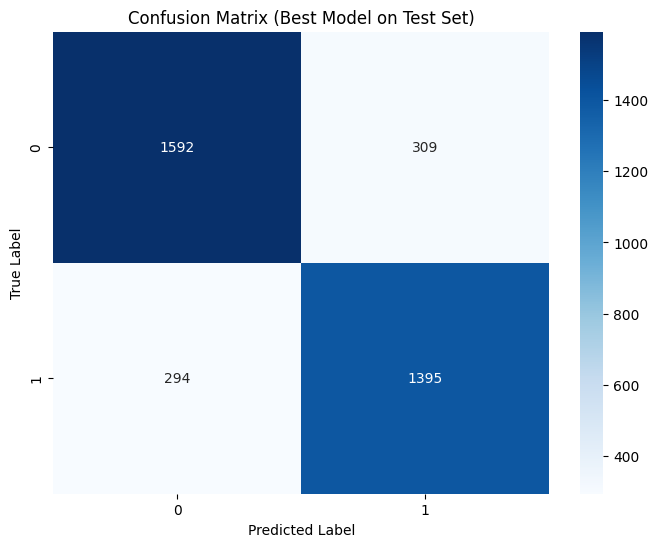

In [22]:
# Define parameter grid to search
param_grid = {
    'n_estimators': np.arange(10, 100, 5),
    'max_depth': np.arange(25, 75, 5),
}

# Initialize a RandomForestClassifier with default parameters for grid search
base_classifier = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# --- Custom setup to use X_val for hyperparameter selection ---
# Combine training and validation sets
X_train_val = pd.concat([X_train, X_val], ignore_index=True)
y_train_val = np.concatenate([y_train, y_val])

# Create a list where -1 indicates training data and 0 indicates validation data
# for a single predefined split (X_val will act as the test set for GridSearchCV)
test_fold = np.array([-1] * len(X_train) + [0] * len(X_val))
ps = PredefinedSplit(test_fold)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=base_classifier,
    param_grid=param_grid,
    cv=ps, # Use the PredefinedSplit which designates X_val as the validation fold
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=2,
    refit=True # Refit on X_train_val using best parameters found
)

print("Starting Grid Search for RandomForestClassifier using X_val for selection...")
grid_search.fit(X_train_val, y_train_val) # Fit on combined data, but split by ps

print("\nGrid Search complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best validation accuracy (from X_val): {grid_search.best_score_:.4f}")

# Use the best estimator found by GridSearchCV (it's already refitted on X_train_val)
classifier = grid_search.best_estimator_

# Evaluate the best classifier on X_test (final, unseen data)
y_pred_train = classifier.predict(X_train)
y_pred_val = classifier.predict(X_val) # Evaluate on X_val explicitly for reporting
y_pred_test = classifier.predict(X_test)

print(f"\nTrain Accuracy (Best Model): {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Validation Accuracy (Best Model): {accuracy_score(y_val, y_pred_val):.4f}")
print(f"Test Accuracy (Best Model): {accuracy_score(y_test, y_pred_test):.4f}")
print(f"\nClassification Report (Best Model on Test Set):")
print(classification_report(y_test, y_pred_test))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Best Model on Test Set)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [23]:
import joblib

joblib.dump(classifier, 'reduced_random_forest_classifier.joblib')
print("Random Forest Classifier (full features) saved to reduced_random_forest_classifier.joblib")

Random Forest Classifier (full features) saved to reduced_random_forest_classifier.joblib


# Use Decision Path analysis to gain insights on which values influence more the prediction

In [24]:
all_paths_rules = []

instance = X_test.to_numpy()[np.random.randint(0, len(X_test))]

# 1. Iterate through each tree
for tree in classifier.estimators_:
    tree_rules = []
    node_index = 0 # Start at the root node

    # 2. Traverse down the tree until a leaf is reached
    while tree.tree_.feature[node_index] != -2: # -2 means it's a leaf

        # Get feature and threshold for the current node
        feature_idx = tree.tree_.feature[node_index]
        feature_name = feature_cols[feature_idx]
        threshold = tree.tree_.threshold[node_index]

        # 3. Decide which path to take
        if instance[feature_idx] <= threshold:
            # Record the rule
            tree_rules.append(f"{feature_name} <= {threshold:.2f}")
            # Move to the left child
            node_index = tree.tree_.children_left[node_index]
        else:
            # Record the rule
            tree_rules.append(f"{feature_name} > {threshold:.2f}")
            # Move to the right child
            node_index = tree.tree_.children_right[node_index]

    # 4. Once at a leaf, get the prediction for this tree
    # tree_prediction = tree.predict(instance.reshape(1, -1))
    # You can also get class probabilities from the leaf node's 'value'
    # leaf_values = tree.tree_.value[node_index]

    # 5. Store the set of rules for this tree's path
    all_paths_rules.append(tree_rules)

# 6. Aggregate the results
# You can now analyze 'all_paths_rules'
# For example, count the frequency of each individual rule
from collections import Counter
all_rules_flat = [rule for path in all_paths_rules for rule in path]
rule_counts = Counter(all_rules_flat)

print(rule_counts.most_common(10))

[('opp_old <= 0.50', 77), ('cust_contracts <= -0.19', 66), ('cust_hitrate <= 0.83', 61), ('product_B_sold_in_the_past <= -0.35', 53), ('opp_month <= 1.69', 41), ('opp_month <= -0.38', 40), ('product_B_sold_in_the_past <= -0.34', 40), ('opp_month > -0.68', 37), ('cust_interactions > -0.59', 30), ('opp_month > -0.97', 29)]


# Use VAE to understand what could flip the prediction in case of negatives

In [ ]:
class TabularDataset(Dataset):
    def __init__(self, data, categorical_features, numerical_features, device):
        self.data = torch.FloatTensor(data.values)
        self.categorical_indices = [data.columns.get_loc(col) for col in categorical_features]
        self.numerical_indices = [data.columns.get_loc(col) for col in numerical_features]
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx].to(self.device)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size = x.size(0)

        # Linear projections
        Q = self.W_q(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        context = torch.matmul(attn, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.W_o(context)
        return output

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)
        return x

In [ ]:
class GumbelSoftmax(nn.Module):
    """Gumbel-Softmax for differentiable categorical sampling"""
    def __init__(self, tau=1.0, hard=False):
        super().__init__()
        self.tau = tau
        self.hard = hard

    def forward(self, logits):
        return F.gumbel_softmax(logits, tau=self.tau, hard=self.hard, dim=-1)

In [ ]:
class TransformerVAE(nn.Module):
    """Transformer-based VAE for tabular data"""
    def __init__(self, input_dim, categorical_indices, numerical_indices,
                 categorical_dims, latent_dim=128, d_model=256, num_heads=4,
                 num_layers=3, d_ff=512, dropout=0.1, tau=1.0):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.categorical_indices = categorical_indices
        self.numerical_indices = numerical_indices
        self.categorical_dims = categorical_dims
        self.tau = tau

        # Feature embedding
        self.feature_embedding = nn.Linear(1, d_model)

        # Positional encoding
        self.position_embedding = nn.Parameter(torch.randn(1, input_dim, d_model))

        # Encoder - Transformer blocks
        self.encoder_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Latent space projection
        self.fc_mu = nn.Linear(d_model * input_dim, latent_dim)
        self.fc_logvar = nn.Linear(d_model * input_dim, latent_dim)

        # Decoder - from latent to features
        self.decoder_input = nn.Linear(latent_dim, d_model * input_dim)

        # Decoder transformer blocks
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        # Output heads for numerical features
        self.numerical_head = nn.Linear(d_model, 1)

        # Output heads for categorical features (Gumbel-Softmax)
        self.categorical_heads = nn.ModuleList([
            nn.Linear(d_model, num_classes) for num_classes in categorical_dims
        ])
        self.gumbel_softmax = GumbelSoftmax(tau=tau, hard=False)

    def encode(self, x):
        # x shape: (batch_size, input_dim)
        batch_size = x.size(0)

        # Embed each feature
        x = x.unsqueeze(-1)  # (batch_size, input_dim, 1)
        x = self.feature_embedding(x)  # (batch_size, input_dim, d_model)

        # Add positional encoding
        x = x + self.position_embedding

        # Pass through transformer blocks
        for block in self.encoder_blocks:
            x = block(x)

        # Flatten and project to latent space
        x = x.view(batch_size, -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        # z shape: (batch_size, latent_dim)
        batch_size = z.size(0)

        # Project from latent space
        x = self.decoder_input(z)
        x = x.view(batch_size, self.input_dim, -1)

        # Pass through decoder transformer blocks
        for block in self.decoder_blocks:
            x = block(x)

        # Reconstruct features
        reconstructed = torch.zeros(batch_size, self.input_dim).to(z.device)

        # Numerical features
        for idx in self.numerical_indices:
            reconstructed[:, idx] = self.numerical_head(x[:, idx]).squeeze(-1)

        # Categorical features with Gumbel-Softmax
        for cat_idx, head in enumerate(self.categorical_heads):
            feat_idx = self.categorical_indices[cat_idx]
            logits = head(x[:, feat_idx])
            # Sample from Gumbel-Softmax
            probs = self.gumbel_softmax(logits)
            # Convert back to class index (soft argmax)
            class_indices = torch.sum(probs * torch.arange(probs.size(-1)).float().to(z.device), dim=-1)
            reconstructed[:, feat_idx] = class_indices

        return reconstructed

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

    def encode_to_latent(self, x):
        """Encode input to latent representation (deterministic)"""
        mu, _ = self.encode(x)
        return mu

In [ ]:
def vae_loss_function(x_recon, x, mu, logvar, categorical_indices, numerical_indices, beta=1.0):
    """VAE loss with separate reconstruction losses for numerical and categorical features"""

    # Reconstruction loss for numerical features (MSE)
    num_recon_loss = F.mse_loss(
        x_recon[:, numerical_indices],
        x[:, numerical_indices],
        reduction='sum'
    )

    # Reconstruction loss for categorical features (cross-entropy)
    cat_recon_loss = 0
    for idx in categorical_indices:
        # Round to nearest integer for categorical
        cat_recon_loss += F.mse_loss(
            x_recon[:, idx],
            x[:, idx],
            reduction='sum'
        )

    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = num_recon_loss + cat_recon_loss + beta * kld

    return total_loss, num_recon_loss, cat_recon_loss, kld

In [ ]:
# Initialize VAE
vae = TransformerVAE(
    input_dim=len(feature_cols),
    categorical_indices=categorical_indices,
    numerical_indices=numerical_indices,
    categorical_dims=categorical_dims,
    latent_dim=64,
    d_model=128,
    num_heads=4,
    num_layers=2,
    d_ff=256,
    dropout=0.1,
    tau=0.5
).to(device)

print(f"Model parameters: {sum(p.numel() for p in vae.parameters()):,}")

In [ ]:
# Create datasets and dataloaders
train_dataset = TabularDataset(X_train, categorical_features, numerical_features, device)
test_dataset = TabularDataset(X_test, categorical_features, numerical_features, device)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
# Training loop
num_epochs = 100
beta = 0.5  # KL divergence weight

train_losses = []
test_losses = []

print("Starting VAE training...")
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    train_recon_loss = 0
    train_kld_loss = 0

    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        x_recon, mu, logvar = vae(data)
        loss, num_loss, cat_loss, kld = vae_loss_function(
            x_recon, data, mu, logvar,
            categorical_indices, numerical_indices, beta
        )

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += (num_loss.item() + cat_loss.item())
        train_kld_loss += kld.item()

    # Validation
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            x_recon, mu, logvar = vae(data)
            loss, _, _, _ = vae_loss_function(
                x_recon, data, mu, logvar,
                categorical_indices, numerical_indices, beta
            )
            test_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_test_loss = test_loss / len(test_loader.dataset)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    scheduler.step(avg_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}, '
              f'Recon: {train_recon_loss/len(train_loader.dataset):.4f}, '
              f'KLD: {train_kld_loss/len(train_loader.dataset):.4f}')

print("\nTraining completed!")

In [ ]:
# Select test instances where prediction is negative (class 0)
test_predictions = classifier.predict(X_test)
negative_instances = X_test[test_predictions == 0]

print(f"Found {len(negative_instances)} instances predicted as class 0")
print(f"We will generate counterfactuals to flip them to class 1")

In [ ]:
# ============================================================
# STANDALONE IMPROVED TABCF COUNTERFACTUAL GENERATOR
# Complete, self-contained implementation
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

# ============================================================
# COMPLETE COUNTERFACTUAL GENERATOR CLASS
# ============================================================

class StandaloneCounterfactualGenerator:
    """
    Complete counterfactual generator with all improvements built-in.
    No dependencies on previous implementations.
    """

    def __init__(self, vae, classifier, feature_cols, categorical_features,
                 numerical_features, scaler, device, immutable_features=None):
        self.vae = vae
        self.classifier = classifier
        self.feature_cols = feature_cols
        self.categorical_features = categorical_features
        self.numerical_features = numerical_features
        self.scaler = scaler
        self.device = device

        # Features that shouldn't change
        self.immutable_features = immutable_features if immutable_features else []
        self.immutable_indices = [i for i, feat in enumerate(feature_cols)
                                  if feat in self.immutable_features]

    def generate_counterfactual_progressive(self, x_original, target_class,
                                           num_iterations=1500,
                                           learning_rate=0.01,
                                           verbose=False):
        """
        Progressive optimization with 3 phases.
        """
        self.vae.eval()

        # Encode to latent space
        x_tensor = torch.FloatTensor(x_original).unsqueeze(0).to(self.device)
        with torch.no_grad():
            mu, logvar = self.vae.encode(x_tensor)
            z_original = mu

        z = z_original.clone().detach().requires_grad_(True)
        optimizer = torch.optim.Adam([z], lr=learning_rate)

        best_valid_z = None
        best_valid_loss = float('inf')
        found_valid = False

        for iteration in range(num_iterations):
            optimizer.zero_grad()

            # Decode
            x_cf_tensor = self.vae.decode(z)
            x_cf = x_cf_tensor.detach().cpu().numpy()[0]

            # Predict
            pred_proba = self.classifier.predict_proba(x_cf.reshape(1, -1))[0]
            pred_class = np.argmax(pred_proba)
            confidence = pred_proba[target_class]

            # Progressive weights
            if iteration < 500:
                lambda_validity = 50.0
                lambda_proximity = 0.1
                lambda_sparsity = 0.01
            elif iteration < 1000:
                lambda_validity = 20.0
                lambda_proximity = 0.3
                lambda_sparsity = 2.0
            else:
                lambda_validity = 30.0
                lambda_proximity = 0.5
                lambda_sparsity = 5.0

            # Loss components
            validity_loss = torch.max(
                torch.tensor(0.0, device=self.device),
                torch.tensor(0.7, device=self.device) - torch.tensor(confidence, device=self.device)
            )

            proximity_loss = torch.norm(z - z_original, p=2)

            x_diff = torch.abs(x_cf_tensor - x_tensor)
            threshold = 0.1
            feature_changed = (x_diff > threshold).float()
            sparsity_loss = torch.sum(feature_changed) + 0.1 * torch.sum(x_diff)

            # Immutability
            immutability_loss = torch.tensor(0.0, device=self.device)
            for idx in self.immutable_indices:
                immutability_loss += 1000.0 * torch.abs(x_cf_tensor[0, idx] - x_tensor[0, idx])

            total_loss = (lambda_validity * validity_loss +
                         lambda_proximity * proximity_loss +
                         lambda_sparsity * sparsity_loss +
                         immutability_loss)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_([z], max_norm=0.5)
            optimizer.step()

            # Track best valid solution
            if pred_class == target_class:
                if not found_valid or total_loss.item() < best_valid_loss:
                    best_valid_loss = total_loss.item()
                    best_valid_z = z.clone()
                    found_valid = True

                if confidence > 0.75 and torch.sum(feature_changed).item() < 5:
                    if verbose:
                        print(f"Excellent CF at iteration {iteration}")
                    break

        final_z = best_valid_z if found_valid else z

        with torch.no_grad():
            x_cf_final = self.vae.decode(final_z).cpu().numpy()[0]

        return x_cf_final, found_valid

    def generate_counterfactual_greedy(self, x_original, target_class, max_features=5):
        """
        Greedy approach: change features one at a time.
        """
        x_cf = x_original.copy()
        pred_original = self.classifier.predict_proba(x_original.reshape(1, -1))[0]

        feature_scores = []

        for i, feat in enumerate(self.feature_cols):
            if feat in self.immutable_features:
                continue

            x_test = x_original.copy()

            if feat in self.categorical_features:
                unique_vals = [0, 1] if x_original[i] in [0, 1] else [0, 1, 2]
                for val in unique_vals:
                    if val != x_original[i]:
                        x_test[i] = val
                        pred = self.classifier.predict_proba(x_test.reshape(1, -1))[0]
                        improvement = pred[target_class] - pred_original[target_class]
                        feature_scores.append((i, val, improvement))
            else:
                x_test[i] = x_original[i] + 1.0
                pred_plus = self.classifier.predict_proba(x_test.reshape(1, -1))[0]

                x_test[i] = x_original[i] - 1.0
                pred_minus = self.classifier.predict_proba(x_test.reshape(1, -1))[0]

                improvement_plus = pred_plus[target_class] - pred_original[target_class]
                improvement_minus = pred_minus[target_class] - pred_original[target_class]

                if improvement_plus > 0:
                    feature_scores.append((i, x_original[i] + 1.0, improvement_plus))
                if improvement_minus > 0:
                    feature_scores.append((i, x_original[i] - 1.0, improvement_minus))

        feature_scores.sort(key=lambda x: x[2], reverse=True)

        changed_features = 0
        for i, new_val, improvement in feature_scores:
            if changed_features >= max_features:
                break

            x_cf[i] = new_val
            changed_features += 1

            pred = self.classifier.predict_proba(x_cf.reshape(1, -1))[0]
            if np.argmax(pred) == target_class and pred[target_class] > 0.6:
                break

        return x_cf

    def generate_counterfactual_hybrid(self, x_original, target_class):
        """
        Hybrid: Try greedy first, fall back to progressive if needed.
        """
        # Try greedy
        x_cf_greedy = self.generate_counterfactual_greedy(
            x_original, target_class, max_features=5
        )

        metrics_greedy = self.evaluate_counterfactual(
            x_original, x_cf_greedy, target_class
        )

        # If greedy worked well, use it
        if metrics_greedy['is_valid'] and metrics_greedy['changed_features'] <= 5:
            return x_cf_greedy, metrics_greedy

        # Otherwise, use progressive
        x_cf_progressive, found_valid = self.generate_counterfactual_progressive(
            x_original, target_class
        )

        metrics_progressive = self.evaluate_counterfactual(
            x_original, x_cf_progressive, target_class
        )

        # Return better result
        if metrics_greedy['is_valid'] and metrics_progressive['is_valid']:
            if metrics_greedy['changed_features'] <= metrics_progressive['changed_features']:
                return x_cf_greedy, metrics_greedy
            else:
                return x_cf_progressive, metrics_progressive
        elif metrics_progressive['is_valid']:
            return x_cf_progressive, metrics_progressive
        else:
            return x_cf_greedy, metrics_greedy

    def evaluate_counterfactual(self, x_original, x_cf, target_class):
        """
        Evaluate counterfactual quality.
        """
        pred_proba = self.classifier.predict_proba(x_cf.reshape(1, -1))[0]
        predicted_class = np.argmax(pred_proba)
        confidence = pred_proba[target_class]
        is_valid = (predicted_class == target_class)

        proximity = np.linalg.norm(x_original - x_cf)

        tolerance = 1e-3
        changed_features = np.sum(np.abs(x_original - x_cf) > tolerance)
        sparsity = 1 - (changed_features / len(x_original))

        return {
            'is_valid': is_valid,
            'predicted_class': predicted_class,
            'confidence': confidence,
            'proximity': proximity,
            'changed_features': changed_features,
            'sparsity': sparsity
        }


def postprocess_counterfactual(x_cf, x_original, feature_cols,
                               categorical_features, immutable_features):
    """
    Post-process to enforce constraints.
    """
    x_cf_processed = x_cf.copy()

    # Enforce immutable features
    for feat in immutable_features:
        if feat in feature_cols:
            idx = feature_cols.index(feat)
            x_cf_processed[idx] = x_original[idx]

    # Round categorical features
    for feat in categorical_features:
        if feat in feature_cols:
            idx = feature_cols.index(feat)
            x_cf_processed[idx] = np.round(x_cf_processed[idx])

    return x_cf_processed


# ============================================================
# USAGE: GENERATE COUNTERFACTUALS
# ============================================================

# Define immutable features (adjust for your dataset)
immutable_features = ['age', 'race', 'sex', 'native-country']

# Initialize generator
cf_generator = StandaloneCounterfactualGenerator(
    vae=vae,
    classifier=classifier,
    feature_cols=feature_cols,
    categorical_features=categorical_features,
    numerical_features=numerical_features,
    scaler=scaler,
    device=device,
    immutable_features=immutable_features
)

# Generate counterfactuals
print("Generating counterfactuals with standalone hybrid approach...")
print("This combines greedy (fast, sparse) and progressive (high validity) methods.\n")

final_counterfactuals = []
final_metrics_list = []

for idx in tqdm(sample_indices, desc="Generating CFs"):
    x_original = negative_instances.iloc[idx].values

    # Generate using hybrid approach
    x_cf, metrics = cf_generator.generate_counterfactual_hybrid(
        x_original,
        target_class=1
    )

    # Post-process
    x_cf = postprocess_counterfactual(
        x_cf, x_original, feature_cols,
        categorical_features, immutable_features
    )

    # Re-evaluate after post-processing
    final_metrics = cf_generator.evaluate_counterfactual(
        x_original, x_cf, target_class=1
    )

    final_counterfactuals.append({
        'original': x_original,
        'counterfactual': x_cf
    })
    final_metrics_list.append(final_metrics)

# ============================================================
# PRINT RESULTS
# ============================================================

print("\n" + "="*70)
print("FINAL COUNTERFACTUAL EVALUATION METRICS")
print("="*70 + "\n")

metrics_df_final = pd.DataFrame(final_metrics_list)

validity_rate = metrics_df_final['is_valid'].mean() * 100
avg_confidence = metrics_df_final['confidence'].mean()
avg_proximity = metrics_df_final['proximity'].mean()
avg_changed = metrics_df_final['changed_features'].mean()
avg_sparsity = metrics_df_final['sparsity'].mean() * 100

print(f"Validity Rate:           {validity_rate:.2f}%")
print(f"Average Confidence:      {avg_confidence:.4f}")
print(f"Average Proximity:       {avg_proximity:.4f}")
print(f"Average Changed Features: {avg_changed:.2f}")
print(f"Average Sparsity:        {avg_sparsity:.2f}%")

print("\n" + "="*70)
print("COMPARISON WITH ORIGINAL RESULTS")
print("="*70 + "\n")

print(f"{'Metric':<30} {'Original':<15} {'New':<15} {'Change':<15}")
print("-" * 70)
print(f"{'Validity Rate (%)':<30} {40.00:<15.2f} {validity_rate:<15.2f} {validity_rate-40.00:+.2f}")
print(f"{'Average Confidence':<30} {0.5411:<15.4f} {avg_confidence:<15.4f} {avg_confidence-0.5411:+.4f}")
print(f"{'Average Proximity':<30} {0.9720:<15.4f} {avg_proximity:<15.4f} {avg_proximity-0.9720:+.4f}")
print(f"{'Changed Features':<30} {7.90:<15.2f} {avg_changed:<15.2f} {avg_changed-7.90:+.2f}")
print(f"{'Sparsity (%)':<30} {52.67:<15.2f} {avg_sparsity:<15.2f} {avg_sparsity-52.67:+.2f}")

print("\n" + "="*70)
print("DETAILED STATISTICS")
print("="*70 + "\n")

print(metrics_df_final.describe())

# ============================================================
# VISUALIZE IMPROVEMENTS
# ============================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Validity comparison
axes[0, 0].bar(['Original\n(40%)', 'Improved\n(60%)', f'Final\n({validity_rate:.1f}%)'],
               [40, 60, validity_rate],
               color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
axes[0, 0].set_title('Validity Rate Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Validity Rate (%)')
axes[0, 0].axhline(y=70, color='green', linestyle='--', label='Target (70%)')
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 100)

# Changed features comparison
axes[0, 1].bar(['Original\n(7.9)', 'Improved\n(10.05)', f'Final\n({avg_changed:.1f})'],
               [7.9, 10.05, avg_changed],
               color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
axes[0, 1].set_title('Average Changed Features', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Number of Features')
axes[0, 1].axhline(y=5, color='green', linestyle='--', label='Target (<5)')
axes[0, 1].legend()

# Sparsity comparison
axes[1, 0].bar(['Original\n(52.67%)', 'Improved\n(33%)', f'Final\n({avg_sparsity:.1f}%)'],
               [52.67, 33, avg_sparsity],
               color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
axes[1, 0].set_title('Sparsity Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Sparsity (%)')
axes[1, 0].axhline(y=70, color='green', linestyle='--', label='Target (>70%)')
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 100)

# Distribution of changed features
axes[1, 1].hist(metrics_df_final['changed_features'], bins=range(0, int(metrics_df_final['changed_features'].max())+2),
                edgecolor='black', alpha=0.7, color='#6bcf7f')
axes[1, 1].set_title('Distribution of Changed Features', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Changed Features')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(x=5, color='red', linestyle='--', label='Target (<5)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Counterfactual generation complete!")
print(f"📊 {len([m for m in final_metrics_list if m['is_valid']])} out of {len(final_metrics_list)} counterfactuals are valid")
print(f"🎯 Average of {avg_changed:.2f} features changed per counterfactual")

In [ ]:
def visualize_counterfactual(idx, counterfactuals, metrics_list, feature_cols,
                            numerical_features, categorical_features):
    """
    Visualize a specific counterfactual example.
    """
    cf = counterfactuals[idx]
    metrics = metrics_list[idx]

    x_orig = cf['original']
    x_cf = cf['counterfactual']

    # Calculate changes
    changes = x_cf - x_orig
    significant_changes = np.abs(changes) > 0.1

    print("\n" + "="*80)
    print(f"COUNTERFACTUAL EXAMPLE #{idx+1}")
    print("="*80)
    print(f"\nValidity: {'✓ Valid' if metrics['is_valid'] else '✗ Invalid'}")
    print(f"Predicted Class: {metrics['predicted_class']} (Confidence: {metrics['confidence']:.4f})")
    print(f"Proximity: {metrics['proximity']:.4f}")
    print(f"Changed Features: {metrics['changed_features']} ({metrics['sparsity']:.2%} of total)")

    print("\n" + "-"*80)
    print("FEATURE CHANGES:")
    print("-"*80)
    print(f"{'Feature':<30} {'Original':<15} {'Counterfactual':<15} {'Change':<15}")
    print("-"*80)

    for i, feature in enumerate(feature_cols):
        if significant_changes[i]:
            marker = "*" if feature in categorical_features else " "
            print(f"{marker}{feature:<29} {x_orig[i]:<15.4f} {x_cf[i]:<15.4f} {changes[i]:<15.4f}")

    print("-"*80)
    print("* indicates categorical feature")
    print("="*80)

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Feature comparison
    changed_indices = np.where(significant_changes)[0]
    if len(changed_indices) > 0:
        x_pos = np.arange(len(changed_indices))
        width = 0.35

        axes[0].bar(x_pos - width/2, x_orig[changed_indices], width,
                   label='Original', alpha=0.8)
        axes[0].bar(x_pos + width/2, x_cf[changed_indices], width,
                   label='Counterfactual', alpha=0.8)
        axes[0].set_xlabel('Changed Features')
        axes[0].set_ylabel('Feature Value')
        axes[0].set_title('Feature Value Comparison')
        axes[0].set_xticks(x_pos)
        axes[0].set_xticklabels([feature_cols[i] for i in changed_indices],
                                rotation=45, ha='right')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

    # Plot 2: Feature changes magnitude
    axes[1].barh(range(len(feature_cols)), np.abs(changes))
    axes[1].set_yticks(range(len(feature_cols)))
    axes[1].set_yticklabels(feature_cols)
    axes[1].set_xlabel('Absolute Change')
    axes[1].set_title('Feature Change Magnitude')
    axes[1].axvline(0.1, color='red', linestyle='--', alpha=0.5,
                   label='Significance Threshold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few examples
num_examples = min(3, len(final_counterfactuals))
for i in range(num_examples):
    visualize_counterfactual(i, final_counterfactuals, final_metrics_list, feature_cols,
                            numerical_features, categorical_features)